In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
con = sqlite3.connect('../data/checking-logs.sqlite.sqlite')

## create a dataframe where each user of the test group has the average difference, number of the pageviews and the number of commits

In [3]:
views = pd.io.sql.read_sql('''
                        SELECT uid, count(*) as pageviews
                        FROM pageviews
                        WHERE uid LIKE 'user_%'
                        GROUP BY uid
                        ''', con)
views.head()

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


## take the number of commits from the checker table

In [4]:
commits = pd.io.sql.read_sql('''
                        SELECT uid, count(*) as num_commits
                        FROM checker
                        WHERE uid LIKE 'user_%' AND labname <> 'project1'
                        GROUP BY uid
                        ''', con)
commits.head()

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86


In [5]:
datamart = pd.io.sql.read_sql('''
            SELECT checker.uid, checker.labname, 
                checker.timestamp AS  first_commit_ts, 
                pageviews.datetime AS first_view_ts
            FROM checker 
            LEFT JOIN pageviews
            ON checker.uid = pageviews.uid
            WHERE status = "ready" AND
                numTrials = 1 AND
                labname IN ('laba04', 'laba04s', 'laba05', 
                    'laba06', 'laba06s', 'project1') AND
                checker.uid LIKE 'user_%' AND
                (pageviews.datetime =
                    (SELECT MIN(pageviews.datetime)
                    FROM pageviews
                    WHERE uid = checker.uid)
                    OR pageviews.datetime IS NULL)''', con, 
                              parse_dates = ['first_commit_ts', 'first_view_ts'])

In [6]:
test = datamart[datamart['first_view_ts'].notna()].reset_index(drop=True)

In [7]:
test['avg_diff'] = ((test['first_view_ts'] - test['first_commit_ts']).dt.total_seconds()).div(3600)

In [8]:
test = test.groupby(['uid'])['avg_diff'].mean().reset_index()

In [9]:
res = test.merge(views, how='inner', on='uid').merge(commits, how='inner', on='uid')

## the figsize is still the same, the fontsize you can choose whatever you like as well as the color palette
## the size of the dots should be 200
## the width of the lines of the diagonal graphs (kde) should be 3

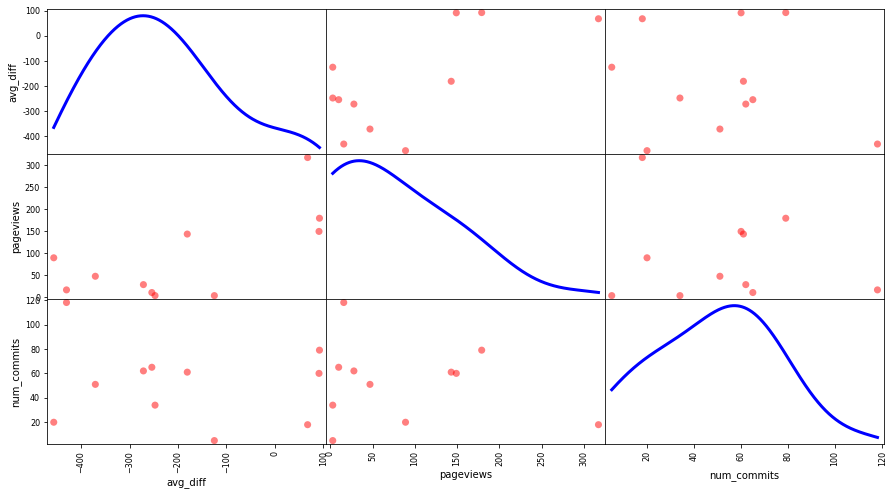

In [10]:
ax = scatter_matrix(res, figsize=(15,8), diagonal='kde',
                    density_kwds=dict(color='blue', linewidth=3),
                    s=200, color='red')

## Can we say that if a user has a low number of pageviews then they likely have a low number of commits?

yes

## Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?

yes

## Can we say that there are many users with a low number of commits and a few – with a high number of commits

yes

## Can we say that there are many users with a small average difference and a few – with a large average difference

no